# FEM Module Example

In [ ]:
#Imports

import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import matplotlib.pyplot as plt
from skfem.visuals.matplotlib import plot
from jaxopt import LBFGS
import skfem as fem
from skfem.helpers import dot, grad
import meshio
import numpy as np
from skfem import MeshQuad

In [ ]:
import numpy as np
import numpy.typing as npt

import skfem as fem
import jax.numpy as jnp

import matplotlib.pyplot as plt

class FEMSystem:

    # Mesh, Element, Basis
    mesh:fem.Mesh = None 
    element:fem.AbstractBasis = None 
    intorder:int = 1
    basis:fem.Basis = None

    # Size of Problem
    elements:int = 0
    quad_per_element:int = 0
    dofs:int = 0

    # Boundary Information
    boundary_condition = 0
    all_dofs = None
    boundary_dofs = None
    interior_dofs = None

    # Weights
    weights = []

    # Interpolation Matrices
    phi_val = None
    phi_grad = None

    # Miscellanous
    dofmap = None
    node_coords_global = None
    X_ref = None
    W_ref = None

    # Constructor - Preprocess Basis
    def __init__(self,mesh,element,intorder,boundary_condition=0):

        # First set mesh, element, intorder and basis
        self.mesh = mesh
        self.element = element
        self.intorder = intorder
        self.basis = fem.CellBasis(mesh, element, intorder=intorder)

        # Step 1: Get boundary information
        self.boundary_condition = boundary_condition
        self.all_dofs = jnp.arange(self.basis.N)
        self.dofs = len(self.all_dofs)
        self.boundary_dofs = self.basis.get_dofs().flatten()
        self.interior_dofs = np.setdiff1d(self.all_dofs, self.boundary_dofs)

        # Step 2: Get Weights
        weights = jnp.array(self.basis.dx) # Only for quadrature points, not necessarily the nodes
        elements,quad_per_element = weights.shape[0],weights.shape[1]
        self.weights,self.elements,self.quad_per_element = weights,elements,quad_per_element

        # Step 3: Get Interpolation Matrices, phi_val and phi_grad
        X_ref,W_ref = self.basis.quadrature
        n_local_dofs = element.refdom.nnodes # 3 for Triangle
        val_list = []
        grad_list = []
        # Loop over local nodes to get basis functions
        for i in range(n_local_dofs):
            dfield = element.gbasis(self.basis.mapping, X_ref, i)[0]
            val_list.append(dfield.value) # (elements,quadratures), value of ith basis function, at quadrature point, in this element
            grad_list.append(dfield.grad) # (dimensions,elements,quadratures), value of the derivative in a direction, of the ith basis function, at quadrature point, in this element
        phi_val = jnp.array(np.stack(val_list)).transpose(1, 2, 0) # eth index is interpolation matrix for element e
        phi_grad = jnp.array(np.stack(grad_list)).transpose(2, 1, 3, 0) #eth index, array at dth index, is interpolation matrix for element e 
        self.phi_val,self.phi_grad = phi_val,phi_grad

        # Step 4: Get Miscellanous Things
        self.dof_map = self.basis.element_dofs.T        
        self.node_coords_global = jnp.array(mesh.doflocs.T)
        self.doflocs = self.basis.doflocs
        self.X_ref,self.W_ref = X_ref,W_ref


    
    '''
    Arguments:
    - u_global: array of values at degrees of freedom. 
    '''
    def _interpolate_values(self,u_global):
        u_local_arr = u_global[self.dof_map] # for every element, get the actual dof value at the nodes in the element
        u_quad = jnp.einsum('eqd,ed... -> eq...',self.phi_val,u_local_arr) # for every element, the interpolated values of the quadrature points. Same dims as weights!!! e for "element", q for "quadrature", d for "degree of freedom / node"
        return u_quad

    def _interpolate_grad(self,u_global):
        u_local_arr = u_global[self.dof_map] # for every element, get the actual dof value at the nodes in the element
        grad_quad = jnp.einsum('exqd,ed -> xeq',self.phi_grad,u_local_arr) # add in axis "x", for the spatial dimension, direction to take gradient in. 
        return grad_quad
    
    def _complete_arr(self,interior_vals):
        u_full = jnp.zeros(self.dofs)
        u_full = u_full.at[self.interior_dofs].set(interior_vals)
        return u_full

    # With boundary conditions
    def _get_at_nodes(self,func):
        x,y = self.doflocs[0],self.doflocs[1]
        x,y = x[self.interior_dofs], y[self.interior_dofs] #truncate array to just interior DOF indices
        interior_vals = func(x,y) 
        full_vals = self._complete_arr(interior_vals) # values at nodes 
        return full_vals
    
    '''
    Arguments:
    - vals: values at quadratures, flattened array.
    '''
    def plot_at_quad(self,vals,plot_title=""):
        coords = self.basis.mapping.F(self.X_ref) 
        flat_coords = coords.reshape(2, -1)

        plt.figure(figsize=(8, 8))
        sc = plt.scatter(flat_coords[0], flat_coords[1], c=vals, s=5, cmap='viridis')

        # 3. Add colorbar and formatting
        plt.colorbar(sc)
        plt.title(plot_title)
        plt.axis('equal')
        plt.show()
    
    '''
    Arguments: 
    - func(x,y): function to plot, with boundary conditions at self.boundary_condition
    '''
    def plot_values_2d(self,func,plot_title="Values at Quadratures, for a 2D Function"):
        u_global = self._get_at_nodes(func)

        # Get at quadratures and plot
        u_quad = self._interpolate_values(u_global)
        self.plot_at_quad(u_quad,plot_title)

    def plot_laplacian_2d(self,func,plot_title="Laplacian at Quadratures, for a 2D Function"):
        u_global = self._get_at_nodes(func)

        # Get at quadratures and plot
        grad_quad = self._interpolate_grad(u_global)
        grad_quadx,grad_quady = self._interpolate_grad(u_global)
        laplacian_quad = grad_quadx**2 + grad_quady**2
        self.plot_at_quad(laplacian_quad,plot_title)

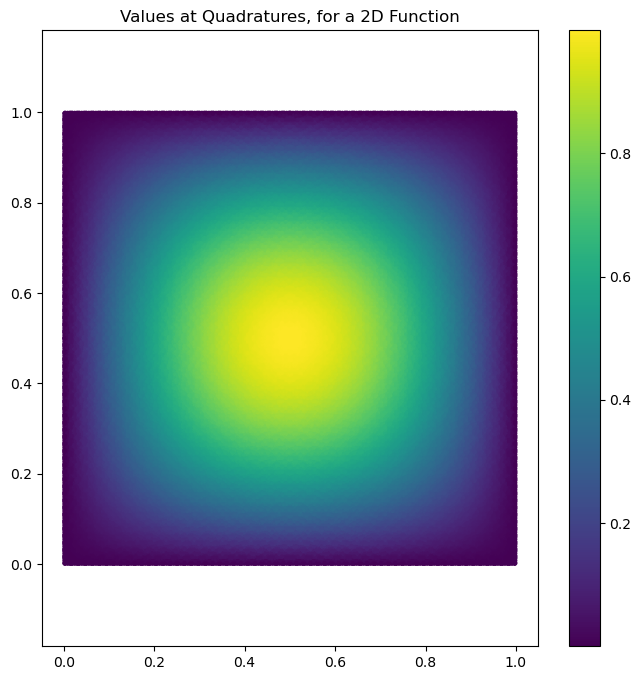

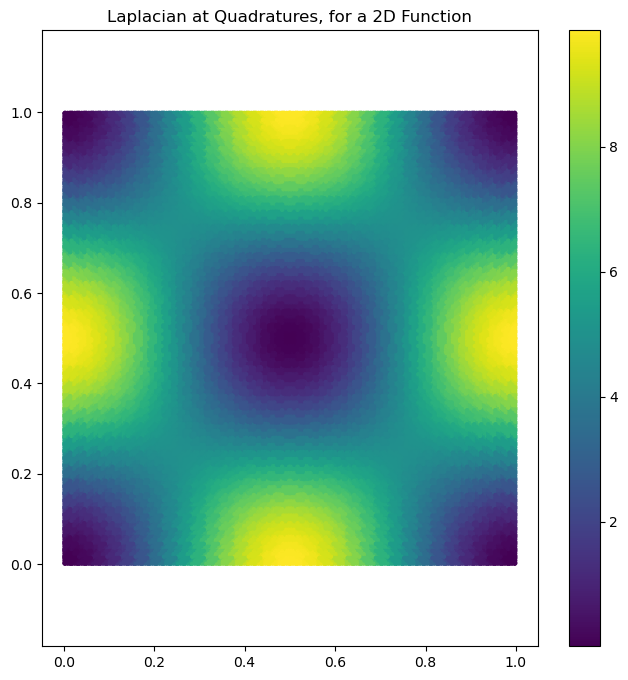

In [30]:
mesh = fem.MeshTri.init_sqsymmetric().refined(5)
element = fem.ElementTriP1()
intorder = 4 # High order to capture everything accurately

femsystem = FEMSystem(mesh,element,intorder)

def v(x,y):
    return jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

femsystem.plot_values_2d(v)
femsystem.plot_laplacian_2d(v)